This notebook demonstrates steps of creating a pipeline of model training and testing

<!-- %pip install -q transformers datasets evaluate -->

In [ ]:
!git clone https://github.com/OopsWrongCode/nlp-project.git

In [ ]:
%cd nlp-project/

In [ ]:
%pip install -q transformers

In [ ]:
import random
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
# from datasets import Dataset

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
train = pd.read_csv('/kaggle/working/nlp-project/data/train.csv')
test = pd.read_csv('/kaggle/working/nlp-project/data/test.csv')
validation = pd.read_csv('/kaggle/working/nlp-project/data/valid.csv')

In [ ]:
train['token_count'] = [len(sentence.split()) for sentence in train['text']]
train['text_length'] = [len(seq) for seq in train['text']]

In [ ]:
train.head()

In [ ]:
validation.head()

In [ ]:
test.head()

In [ ]:
mbti_types = train['label'].unique().tolist()

label_encoder = LabelEncoder()
label_encoder.fit(mbti_types)

train['label'] = label_encoder.transform(train['label'])
validation['label'] = label_encoder.transform(validation['label'])
test['label'] = label_encoder.transform(test['label'])


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

class MBTIDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = str(self.texts[index])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        if self.labels is not None:
            label = self.labels[index]
            return {
                'input_ids': encoding['input_ids'].squeeze(0),  # (max_len)
                'attention_mask': encoding['attention_mask'].squeeze(0),  # (max_len)
                'labels': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': encoding['input_ids'].squeeze(0),  # (max_len)
                'attention_mask': encoding['attention_mask'].squeeze(0),  # (max_len)
            }

    def __len__(self):
        return len(self.texts)

In [ ]:
print(f"Max len = {np.max(train['token_count'])}\nMin len = {np.min(train['token_count'])}\nAvg len = {np.round(np.mean(train['token_count']), 2)}")

In [59]:
BATCH_SIZE = 32
MAX_LEN = np.max(train['token_count'])
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = MBTIDataset(texts=train['text'].tolist(), labels=train['label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN)
test_dataset = MBTIDataset(texts=test['text'].tolist(),labels=test['label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN)
validation_dataset = MBTIDataset(texts=validation['text'].tolist(), labels=validation['label'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

For regularization, we employ two commonly used
techniques: dropout (Hinton et al., 2012) and L2
weight regularization. We apply dropout to prevent co-adaptation. In our model, we either apply
dropout to word vectors before feeding the sequence
of words into the convolutional layer or to the output
of LSTM before the softmax layer. The L2 regularization is applied to the weight of the softmax layer. (https://arxiv.org/pdf/1511.08630)

In [ ]:
class MyLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim=6, num_layers=1, bidirectional=False, dropout=0.3, fc_dropout=0.3, input_dropout=0.2):
        super(MyLSTM, self).__init__()

        
        self.input_dropout = nn.Dropout(input_dropout) # 

        self.lstm = nn.LSTM(
            input_size=embedding_dim, # 768
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        # LAYER 2: Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(
            hidden_dim * (2 if bidirectional else 1),
            output_dim
        )

    def forward(self, bert_embeddings):  # [batch_size, seq_len, embedding_dim]

        # Dropout on BERT-embeddings
        x = self.input_dropout(bert_embeddings)

        lstm_output, (h_n, c_n) = self.lstm(x)

        if self.lstm.bidirectional:
            h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_final = h_n[-1]

        h_final = self.fc_dropout(h_final)
        out = self.fc(h_final)
        return out

In [ ]:
class MyGRU(nn.Module):
    def __init__(self, input_dim, embedding_dim=50, hidden_dims=[120, 64, 64], output_dim=6, dropout=0.5, fc_dropout=0.1):
        super(MyGRU, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.gru1 = nn.GRU(embedding_dim, hidden_dims[0], bidirectional=True, batch_first=True)
        self.gru2 = nn.GRU(hidden_dims[0] * 2, hidden_dims[1], bidirectional=True, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_dims[1] * 2)
        self.gru3 = nn.GRU(hidden_dims[1] * 2, hidden_dims[2], bidirectional=True, batch_first=True)
        
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dims[2] * 2, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)  # (batch_size, maxlen) -> (batch_size, maxlen, embedding_dim)
        x = self.dropout(x)
        
        # first GRU
        gru_out1, _ = self.gru1(x)  # (batch_size, maxlen, hidden_dims[0] * 2)
        # second GRU
        gru_out2, _ = self.gru2(gru_out1)  # (batch_size, maxlen, hidden_dims[1] * 2)
        # batch_norm
        gru_out2 = gru_out2.permute(0, 2, 1)  # (batch_size, hidden_dims[1] * 2, maxlen)
        gru_out2 = self.batch_norm(gru_out2)  # Apply batch norm
        gru_out2 = gru_out2.permute(0, 2, 1)  # (batch_size, maxlen, hidden_dims[1] * 2)
        # third GRU
        _, h_n = self.gru3(gru_out2)  # h_n: (num_directions, batch_size, hidden_dims[2])
        
        # bidirectional stage
        h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)  # (batch_size, hidden_dims[2] * 2)
        
        h_final = self.fc_dropout(h_final)
        out = self.fc(h_final)  # (batch_size, output_dim)
        out = self.softmax(out)
        return out

In [72]:
class MyGRU(nn.Module):
    def __init__(self, bert_embedding_dim=768, embedding_dim=256, hidden_dim=128, output_dim=6, num_layers=2, bidirectional=False, dropout=0.3, fc_dropout=0.1, input_dropout=0.2):
        super(MyGRU, self).__init__()

        # reduce bert embeds to embedding_dim
        self.embedding_projection = nn.Linear(bert_embedding_dim, embedding_dim)
        self.input_dropout = nn.Dropout(input_dropout)
        self.norm = nn.LayerNorm(embedding_dim)

        # GRU layer
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, bert_embedding_dim=768)
        x = self.embedding_projection(x)  # Project to (batch_size, sequence_length, embedding_dim=256)
        x = self.norm(x) 
        x = self.input_dropout(x)
        # Pass through GRU
        gru_output, h_n = self.gru(x)

        # Extract final hidden state
        if self.gru.bidirectional:
            h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_final = h_n[-1]

        # Apply dropout and FC layer
        h_final = self.fc_dropout(h_final)
        out = self.fc(h_final)
        return out

In [ ]:
# C-LSTM: https://arxiv.org/pdf/1511.08630

class HybridNN(nn.Module):
    def __init__(self, embedding_dim=768, conv_out_channels=256, kernel_size=3, 
                 hidden_dim=256, output_dim=6, lstm_layers=2, bidirectional=True, 
                 dropout=0.4, fc_dropout=0.2, input_dropout=0.1):
        super(HybridNN, self).__init__()

        self.input_dropout = nn.Dropout(input_dropout)

        # CNN block
        self.conv1 = nn.Conv1d(in_channels=embedding_dim,
                               out_channels=conv_out_channels,
                               kernel_size=kernel_size,
                               padding=1)
        self.conv2 = nn.Conv1d(in_channels=conv_out_channels,
                               out_channels=conv_out_channels,
                               kernel_size=kernel_size,
                               padding=1)

        self.spatial_dropout = nn.Dropout2d(0.3)
        self.relu = nn.ReLU()

        # LSTM
        self.lstm = nn.LSTM(input_size=conv_out_channels,
                            hidden_size=hidden_dim,
                            num_layers=lstm_layers,
                            bidirectional=bidirectional,
                            dropout=dropout if lstm_layers > 1 else 0,
                            batch_first=True)

        self.attn_linear = nn.Linear(hidden_dim * (2 if bidirectional else 1), 1)

        # Output
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)

    def forward(self, embeddings):
        # Dropout input
        x = self.input_dropout(embeddings)  # [batch_size, seq_len, embedding_dim]
        # Conv1D
        x = x.permute(0, 2, 1)                 # [B, seq, emb]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.permute(0, 2, 1)                 # LSTM
        x = self.spatial_dropout(x) 


        # LSTM
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim*2]

        #attention mechanism
        attn_weights = torch.softmax(self.attn_linear(lstm_out), dim=1)  # [batch_size, seq_len, 1]
        attn_output = torch.sum(lstm_out * attn_weights, dim=1)  # [batch_size, hidden_dim*2]

        # FC
        out = self.fc_dropout(attn_output)
        out = self.fc(out)

        return out

In [ ]:
from transformers import AutoModel

bert = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train.label), y=train.label)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

In [ ]:
class_weights

In [ ]:
# class_weights[5] = class_weights[5] * 1.15

In [66]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# VOCAB_SIZE = len(tokenizer)

gru_model = MyGRU(embedding_dim=256, hidden_dim=128, output_dim=6, num_layers=3, dropout=0.3,fc_dropout=0.3, bidirectional=True).to(DEVICE)

gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
gru_scheduler = ReduceLROnPlateau(gru_optimizer, patience=3, factor=0.1)

In [ ]:
lstm_model = MyLSTM(embedding_dim=768, hidden_dim=128, output_dim=6, num_layers=3, dropout=0.5, bidirectional=True,fc_dropout=0.3, input_dropout=0.2).to(DEVICE)

lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=0.0001)
lstm_scheduler = ReduceLROnPlateau(lstm_optimizer, patience=3, factor=1e-2)
# lstm_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(lstm_optimizer, T_0=5, T_mult=2)

In [ ]:
hybrid_model = HybridNN(embedding_dim=768, conv_out_channels=128, kernel_size=4, 
                 hidden_dim=128, output_dim=6, lstm_layers=2, bidirectional=True, 
                 dropout=0.4, fc_dropout=0.2, input_dropout=0.1).to(DEVICE)

hybrid_optimizer = optim.Adam(hybrid_model.parameters(), lr=0.001, weight_decay=0.0001)
hybrid_scheduler = ReduceLROnPlateau(hybrid_optimizer, patience=3, factor=1e-2)

In [51]:
import copy

class EarlyStopper:
    def __init__(self, model, patience=3, min_delta=0.01, restore_best_weights=True, save_weights=False):
        self.model = model
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_weights = None
        self.restore_best_weights = restore_best_weights
        self.save_weights = save_weights

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = copy.deepcopy(self.model.state_dict())

        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.load_state_dict(self.best_weights)
                    if self.save_weights:
                        torch.save(self.best_weights, f'{self.model.__class__.__name__}_best_weights.pt')
                        print(f"Weights has been saved")
                return True

        return False

# source: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

In [73]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

EPOCHS = 25
MODEL = gru_model
OPTIMIZER = gru_optimizer
SCHEDULER = gru_scheduler
lr_history = []
early_stopper = EarlyStopper(patience=4, model=MODEL, min_delta=0.01, save_weights=False)

for epoch in range(EPOCHS):
    MODEL.train()
    running_loss = 0.0

    for batch in train_loader:
        OPTIMIZER.zero_grad() # replace

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        with torch.no_grad():  # BERT embed
            bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_output.last_hidden_state  # [batch_size, seq_len, 768]

        outputs = MODEL(embeddings) #replace
        loss = loss_fn(outputs, labels)

        loss.backward()
        OPTIMIZER.step() #replace

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # === VALIDATION ===
    MODEL.eval() #replace
    val_preds = []
    val_labels = []
    val_loss_total = 0.0

    with torch.no_grad():
        for batch in validation_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = bert_output.last_hidden_state

            outputs = MODEL(embeddings) #replace
            loss = loss_fn(outputs, labels)

            val_loss_total += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss_total / len(validation_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    SCHEDULER.step(avg_val_loss) # replace 
    current_lr = OPTIMIZER.param_groups[0]['lr'] #replace
    lr_history.append(current_lr)

    if early_stopper.early_stop(avg_val_loss):             
        print(f"Early stopping at epoch {epoch+1}")
        break


    print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

class_report = classification_report(val_labels, val_preds, target_names=[str(i) for i in range(6)])
print(f"Classification Report:\n{class_report}")

print("Train finished")

Epoch 1/25 — Train Loss: 0.2553 | Val Loss: 0.6034 | Val Acc: 0.8123
Epoch 2/25 — Train Loss: 0.2538 | Val Loss: 0.6112 | Val Acc: 0.8118
Epoch 3/25 — Train Loss: 0.2560 | Val Loss: 0.6153 | Val Acc: 0.8108
Epoch 4/25 — Train Loss: 0.2499 | Val Loss: 0.6154 | Val Acc: 0.8113
Early stopping at epoch 5
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       274
           1       0.73      0.77      0.75       212
           2       0.88      0.82      0.85       703
           3       0.62      0.78      0.69       178
           4       0.90      0.81      0.85       550
           5       0.63      0.89      0.74        81

    accuracy                           0.81      1998
   macro avg       0.76      0.81      0.78      1998
weighted avg       0.82      0.81      0.81      1998

Train finished


In [ ]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score

# EPOCHS = 25
# MODEL = hybrid_model
# OPTIMIZER = hybrid_optimizer
# SCHEDULER = hybrid_scheduler
# lr_history = []
# early_stopper = EarlyStopper(patience=4, model=MODEL, min_delta=0.01, save_weights=False)

# for epoch in range(EPOCHS):
#     MODEL.train()
#     bert.train()
#     running_loss = 0.0

#     for batch in train_loader:
#         OPTIMIZER.zero_grad() # replace

#         input_ids = batch['input_ids'].to(DEVICE)
#         attention_mask = batch['attention_mask'].to(DEVICE)
#         labels = batch['labels'].to(DEVICE)

#         bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
#         embeddings = bert_output.last_hidden_state

#         outputs = MODEL(embeddings) #replace
#         loss = loss_fn(outputs, labels)

#         loss.backward()
#         OPTIMIZER.step() #replace

#         running_loss += loss.item()

#     avg_train_loss = running_loss / len(train_loader)

#     # === VALIDATION ===
#     MODEL.eval() #replace
#     val_preds = []
#     val_labels = []
#     val_loss_total = 0.0

#     with torch.no_grad():
#         for batch in validation_loader:
#             input_ids = batch['input_ids'].to(DEVICE)
#             attention_mask = batch['attention_mask'].to(DEVICE)
#             labels = batch['labels'].to(DEVICE)

#             bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
#             embeddings = bert_output.last_hidden_state

#             outputs = MODEL(embeddings) #replace
#             loss = loss_fn(outputs, labels)

#             val_loss_total += loss.item()

#             preds = torch.argmax(outputs, dim=1)
#             val_preds.extend(preds.cpu().numpy())
#             val_labels.extend(labels.cpu().numpy())

#     avg_val_loss = val_loss_total / len(validation_loader)
#     val_acc = accuracy_score(val_labels, val_preds)

#     SCHEDULER.step(avg_val_loss) # replace 
#     current_lr = OPTIMIZER.param_groups[0]['lr'] #replace
#     lr_history.append(current_lr)

#     if early_stopper.early_stop(avg_val_loss):             
#         print(f"Early stopping at epoch {epoch+1}")
#         break


#     print(f"Epoch {epoch+1}/{EPOCHS} — Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# class_report = classification_report(val_labels, val_preds, target_names=[str(i) for i in range(6)])
# print(f"Classification Report:\n{class_report}")

# print("Train finished")

In [74]:
if early_stopper.best_weights is not None:
    MODEL.load_state_dict(early_stopper.best_weights)
    print("Best weights loaded after training")
else:
    print("No best weights were saved")

MODEL.eval()

test_preds = []
test_labels = []
test_loss_total = 0.0

with torch.no_grad():

    for batch in test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        bert_output = bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = bert_output.last_hidden_state

        outputs = MODEL(embeddings)
        loss = loss_fn(outputs, labels)
        test_loss_total += loss.item()


        preds = torch.argmax(outputs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())



avg_test_loss = test_loss_total / len(test_loader)
test_acc = accuracy_score(test_labels, test_preds)

print(f"Validation Loss: {avg_test_loss:.4f} | Validation Accuracy: {test_acc:.4f}")

class_report = classification_report(test_labels, test_preds, target_names=[str(i) for i in range(6)])

print(f"Classification Report:\n{class_report}")

Best weights loaded after training
Validation Loss: 0.7013 | Validation Accuracy: 0.8000
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       275
           1       0.79      0.74      0.76       224
           2       0.90      0.81      0.85       695
           3       0.50      0.79      0.62       159
           4       0.93      0.81      0.87       581
           5       0.47      0.80      0.59        66

    accuracy                           0.80      2000
   macro avg       0.72      0.79      0.74      2000
weighted avg       0.83      0.80      0.81      2000



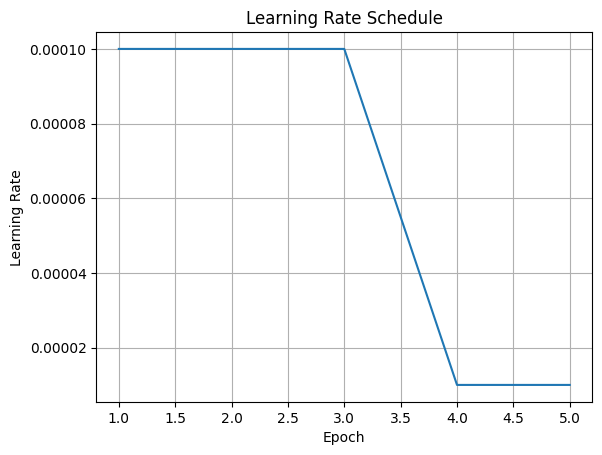

In [62]:
plt.plot(range(1, len(lr_history) + 1), lr_history)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()